# Physiological Predictors: Using Cleveland Metrics to Predict Heart Disease
**Brian Shao, 49953300**

## Introduction

### Background
According to the Government of Canada (2017), heart disease the second leading cause of death in Canada. In fact, data
from the Canadian Chronic Disease Surveillance System indicates that between 2017 and 2018, over 8% of adults in Canada
were diagnosed with heart disease (Government of Canada, 2017). The death rate for heart disease is similarly surprising:
Adults with heart disease are almost three times as likely to die than adults who do not, a rate which increases to 4.6 times
if a heart attack has been experienced.

Given the prevalence and significant dangers of heart disease, it is extremely important to investigate potential methods
of reducing its risks or effects.
Early detection of heart disease is one of the most useful tools healthcare professions have of mitigating the risks of heart disease.
According to University of Ottawa Heart Institute (n.d.), identifying heart disease early is crucial in minimizing further damage.
Similarly, identifying those who are at risk of heart disease and treating the associated risks significantly reduces the
odds of a heart attack or other heart-disease related incidents (Ottawa Heart Institute, n.d.).

Therefore, to reduce the effects of heart disease, the ability to detect heart disease is crucial to effective treatment.
By finding a way to better detect heart disease, it may be possible to prevent many out of the tens of thousands of deaths
in Canada that occur because of heart disease each year.

This project will attempt to create a predictive model for heart disease using demographic and physiological metrics,
such as age, cholesterol, and heart rate. In doing so, I hope to create a system that can aid health care professionals
in medial decision-making when it comes to hear disease diagnoses.

### Research Question
For this project, I will investigate the following research question:

How well can a predictive model determine the presence of heart disease using demographic and physiological measurements?

### Dataset
This project used a modified version of the UCI Heart Disease dataset published by Janosi et al. (1988), which contains information from patients in
Cleveland, Ohio. The dataset contains 14 attributes in patients, such as age, sex, and heart rate, which was used to
train and test the model. In this project, only five of the available attributes from the dataset were used.


## Methods & Results

To answer the research question, a classification model using the k-nearest neighbors strategy was used. Four variables
from the UCI Heart Disease dataset was used as predictors for the model: age (`age`), resting blood pressure (`trestbps`),
serum cholesterol (`chol`), and maximum heart rate (`thalach`). The presence of heart disease (`target`) was used as
the response variable.

The data was first loaded from the provided csv file. Only the Cleveland dataset was used in this project, since it had
the most usable data and minimal omitted columns. The data was parsed and wrangled into a tidy format using the UCI database's
labels and format specification. Variable names and values were re-organized so that they were easier to identify or work with,
such as by renaming factor columns from integer enumerations to string names, without altering the meaning of the values.

Next, the model was tuned to find the optimal parameters (i.e. `k`, the number of neighbors). This was performed using
five-fold cross-validation on the training dataset for potential `k` values between 1 and 30. The `k` value that yielded 
the highest accuracy during cross-validation was selected for the final model.

The final model was trained using the training data. The resulting model was used to generated predictions, evaluated on the testing data.
Metrics for the model's predictions were collected, in order to generate a confusion matrix for visualizing the overall performance.
The precision and recall values were calculated using the confusion matrix to evaluate and quantify the final performance of the model.

First, all required libraries are imported, and formatting options are set.

In [1]:
# 0. Library imports and initialization

library('repr')
library('tidyverse')
library('tidymodels')

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ 

Next, the data is loaded from the processed.cleveland.data file, which is formatted as a csv file. Column names are assigned according to the names and order specified in the UCI database. In total, 14 columns are loaded. Additional values that correspond to (`"?"`) are specified, since they appear in the raw data.

In [2]:
# 1. Read data and assign column names using names in UCI databse

col_names <- c('age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
data <- read_csv(file = 'data/heart_disease/processed.cleveland.data', na = c('', 'NA', '?'), col_names = col_names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


To tidy the data, all of the categorical variables in the dataset are converted from integer values to descriptive string names.
The types of these variables are converted to `factor` to indicate this change. The `target` variable is set according to the
presence of heart disease: When heart disease is present, regardless of the level, `target` is set to `"present"`; otherwise,
it is set to `"absent"`. This is because the model does not differentiate between the levels of heart disease within the UCI
database. Finally, renamed variables are removed from the data to maintain the tidy format.

The pseudo-random number generator is seeded as well. To ensure that the random seed is as accurate as possible, it is
selected using an online random number generator.
The wrangled data is split into training (75%) and testing (25%) sets, with the strata set to `target` as that is the
response variable for the model.

In [3]:
# 2. Wrangle and tidy data

# wrangle data
heart_data <- data |>
  # relabel categorical variables based on the variables table in UCI database
  mutate(sex = as.factor(case_when(sex == 1 ~ 'male', sex == 0 ~ 'female'))) |>
  mutate(cp = as.factor(case_when(cp == 1 ~ 'typical angina', cp == 2 ~ 'atypical angina', cp == 3 ~ 'non-anginal pain', cp == 4 ~ 'asymptomatic'))) |>
  mutate(fbs = as.factor(case_when(fbs == 1 ~ 'true', fbs == 0 ~ 'false'))) |>
  mutate(restecg = as.factor(case_when(restecg == 0 ~ 'normal', restecg == 1 ~ 'abnormality', restecg == 2 ~ 'hypertrophy'))) |>
  mutate(exang = as.factor(case_when(exang == 1 ~ 'yes', exang == 0 ~ 'no'))) |>
  mutate(slope = as.factor(case_when(slope == 1 ~ 'upsloping', slope == 2 ~ 'flat', slope == 3 ~ 'downsloping'))) |>
  mutate(thal = as.factor(case_when(thal == 3 ~ 'normal', thal == 6 ~ 'fixed defect', thal == 7 ~ 'reversable defect'))) |>
  # replace heart disease values with presence or absence
  mutate(target = as.factor(case_when(num == 0 ~ 'absent', num > 0 ~ 'present'))) |>
  # remove renamed variables
  select(-num)

# set prng random
set.seed(52515)

# split data
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- training(heart_split)

Summary statistics are generated for the training dataset. In this table, the mean and standard deviation for the four
predictor variables (age, resting blood pressure, cholesterol, and maximum heart rate) are shown, grouped by whether
heart disease is present (the response variable). The number of rows for both values of the response variable are shown 
as well.

In [4]:
# 3. Summarize training data

summary_table <- heart_train |>
  group_by(target) |>
  summarize(
    count = n(),
    mean_age = mean(age),
    sd_age = sd(age),
    mean_trestbps = mean(trestbps),
    sd_trestbps = sd(trestbps),
    mean_chol = mean(chol),
    sd_chol = sd(chol),
    mean_thalach = mean(thalach),
    sd_thalach = sd(thalach),
  )

summary_table

target,count,mean_age,sd_age,mean_trestbps,sd_trestbps,mean_chol,sd_chol,mean_thalach,sd_thalach
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,123,53.21951,9.744722,129.9756,15.97255,244.3496,58.58145,156.8455,19.50579
present,104,57.18269,7.847780,133.1058,18.08283,251.3654,52.02241,137.8942,22.60678


*(Table 1)*


Next, histograms for each of the four predictor variables are shown, which visualize the distributions for each variable
for rows where heart disease is present and rows where heart disease is absent. These plots are displayed in figures 1-4.

The side-by-side view of the two histograms for each variable allows for relationships and differences to be spotted. For
example, since heart rate and age are the two predictor variables where the histograms are the least alike, that may
indicate that these two variables will end up being weighed higher in the final model. Similarly, since the histograms
for blood pressure and cholesterol seem fairly similar across rows with and without heart disease, these two variables
may not be as strong of a predictor for the presence of heart disease.

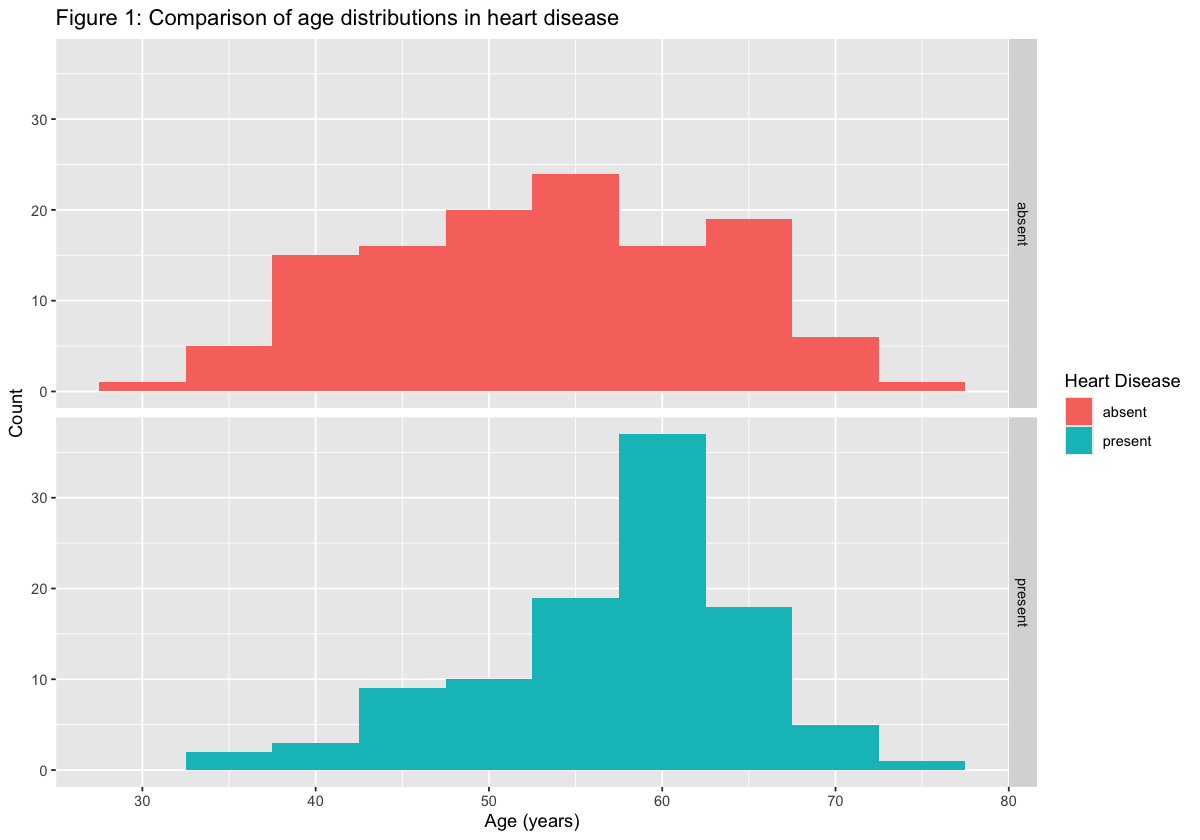

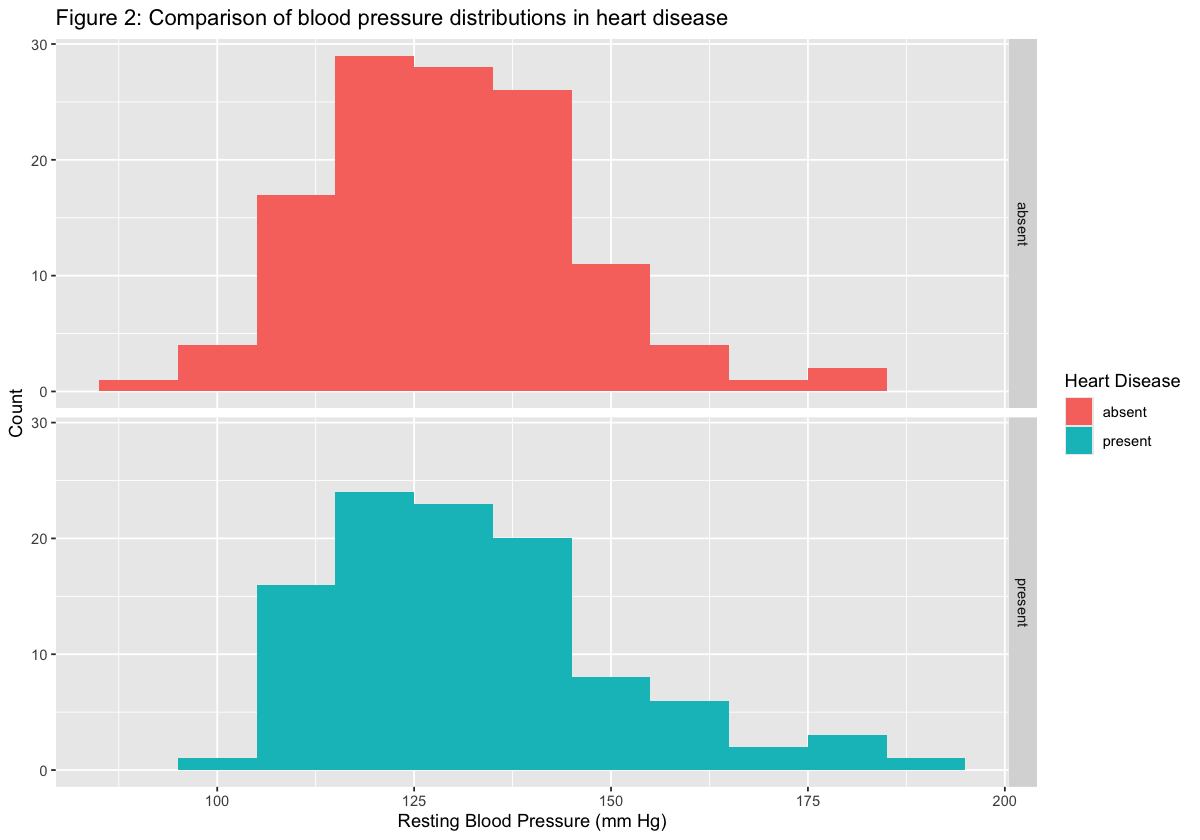

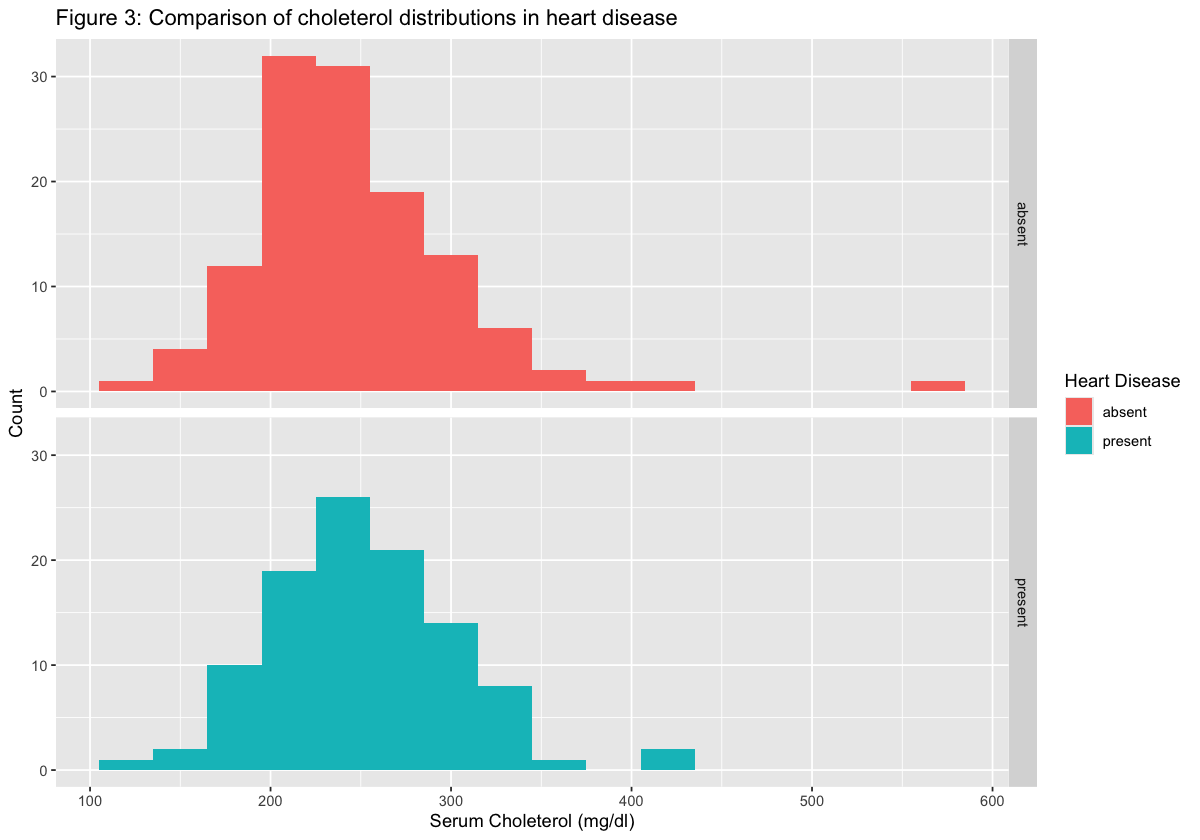

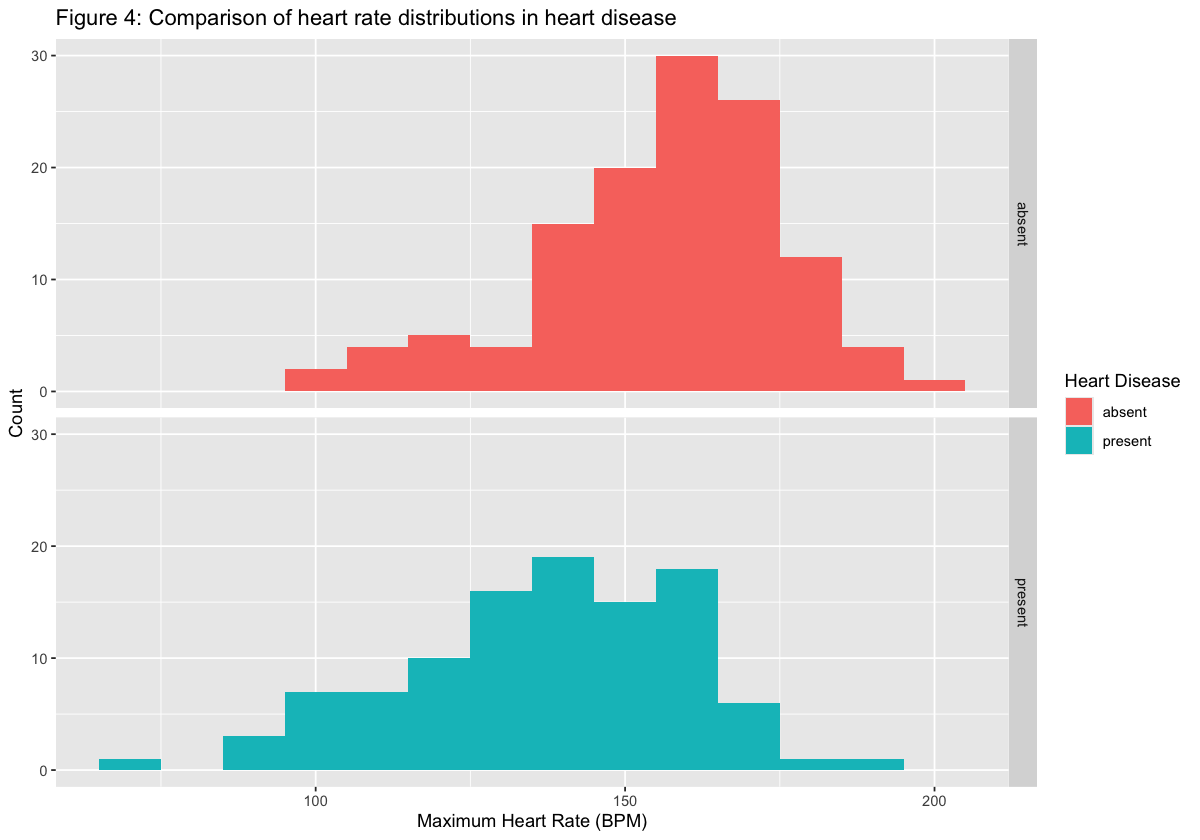

In [5]:
# 4. Visualize training data

heart_train |>
  ggplot(aes(x = age, fill = target)) +
    geom_histogram(binwidth = 5) +
    facet_grid(rows = vars(target)) +
    xlab('Age (years)') +
    ylab('Count') +
    labs(fill = 'Heart Disease') +
    ggtitle('Figure 1: Comparison of age distributions in heart disease')

heart_train |>
  ggplot(aes(x = trestbps, fill = target)) +
  geom_histogram(binwidth = 10) +
  facet_grid(rows = vars(target)) +
  xlab('Resting Blood Pressure (mm Hg)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Figure 2: Comparison of blood pressure distributions in heart disease')

heart_train |>
  ggplot(aes(x = chol, fill = target)) +
  geom_histogram(binwidth = 30) +
  facet_grid(rows = vars(target)) +
  xlab('Serum Choleterol (mg/dl)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Figure 3: Comparison of choleterol distributions in heart disease')

heart_train |>
  ggplot(aes(x = thalach, fill = target)) +
  geom_histogram(binwidth = 10) +
  facet_grid(rows = vars(target)) +
  xlab('Maximum Heart Rate (BPM)') +
  ylab('Count') +
  labs(fill = 'Heart Disease') +
  ggtitle('Figure 4: Comparison of heart rate distributions in heart disease')

To create the model, a tuning step is performed first. A nearest-neighbor model is created for tuning, and cross validation
folds are generated using the training data. Next, a recipe with the identified predictor and response variables is created,
with added steps for scaling and centering the predictors. This is necessary to ensure that all of the predictor variables
are weighted appropriately in the model.

Finally, cross-validation is performed in a workflow against the specified `k` values (between 1 and 30). Metrics are
collected and organized by accuracy value. The `k` value with the highest accuracy is recorded, and a scatter/line plot is
generated to show accuracies for each `k` value, as shown in figure 5.

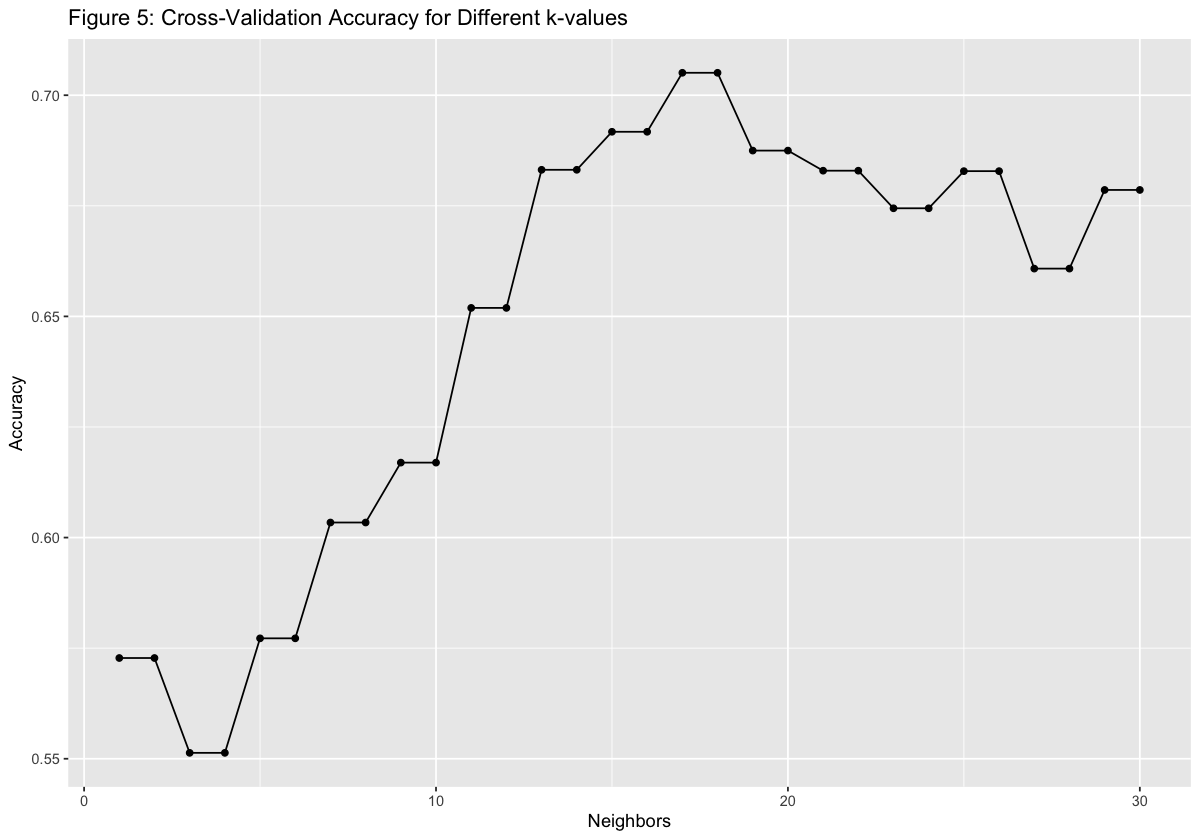

In [6]:
# 5. Tune KNN model

# set prng random
set.seed(52515)

knn_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
  set_engine('kknn') |>
  set_mode('classification')

heart_vfold <- vfold_cv(heart_train, v = 5, strata = target)

heart_model <- recipe(target ~ age + trestbps + chol + thalach, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

cross_val <- workflow() |>
  add_model(knn_spec_tune) |>
  add_recipe(heart_model) |>
  tune_grid(resamples = heart_vfold, grid = tibble(neighbors = seq(1, 30))) |>
  collect_metrics() |>
  filter(.metric == 'accuracy')

tune_k <- cross_val |> 
  arrange(-mean) |>
  select(neighbors) |>
  slice(1) |>
  pull()

cross_val_plot <- ggplot(cross_val, aes(y = mean, x = neighbors)) +
  geom_point() +
  geom_line() +
  xlab('Neighbors') +
  ylab('Accuracy') +
  ggtitle('Figure 5: Cross-Validation Accuracy for Different k-values')

cross_val_plot

Based on figure 5, it can be seen that n=17 is the optimal neighbor count for the model.
Finally, a new k-nearest neighbors classification model is fitted with the training data and n=17 as the number of neighbors.
Then, the fitted model is evaluated by predicting the testing dataset.

In [7]:
# 6. Fit model and evaluate using test data

# set prng random
set.seed(52515)

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune_k) |>
  set_engine('kknn') |>
  set_mode('classification')

heart_predictions <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(heart_model) |>
  fit(data = heart_train) |>
  predict(heart_test) |>
  bind_cols(heart_test)

Using the predictions and the original test data, metrics are collected, and the final confusion matrix is visualized in 
Figure 6.

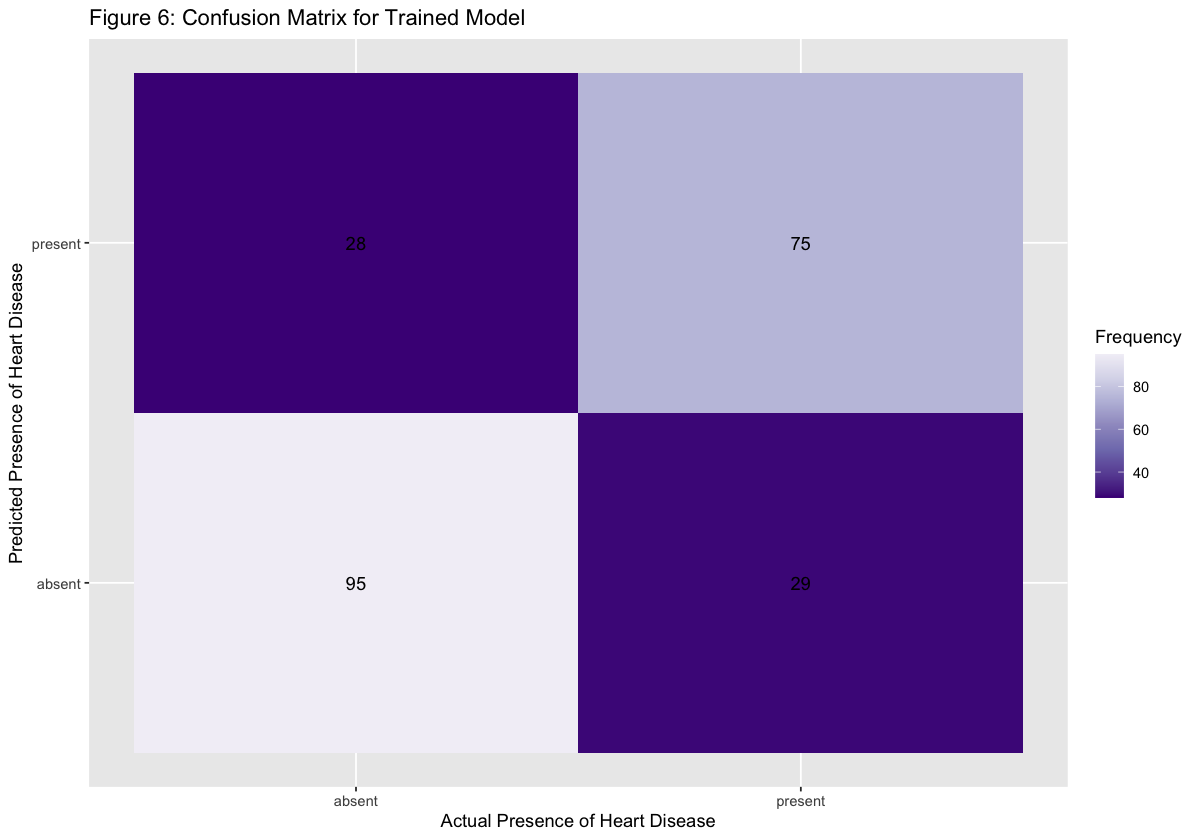

In [8]:
# 7. Calculate metrics

heart_accuracy <- heart_predictions |>
  metrics(truth = target, estimate = .pred_class) |>
  filter(.metric == 'accuracy') |>
  select(.estimate) |>
  pull()

heart_conf_mat <- heart_predictions |>
  conf_mat(truth = target, estimate = .pred_class)

heart_conf_mat_plot <- heart_conf_mat$table |>
  as.data.frame.table() |>
  ggplot(aes(y = Prediction, x = Truth, fill = Freq)) +
    geom_tile() +
    geom_text(aes(label = Freq)) +
    scale_fill_distiller(palette = "Purples") +
    ylab('Predicted Presence of Heart Disease') +
    xlab('Actual Presence of Heart Disease') +
    labs(fill = 'Frequency') +
    ggtitle('Figure 6: Confusion Matrix for Trained Model')

heart_conf_mat_plot

Finally, the precision and recall statistics are calculated using the values from the confusion matrix.
The precision was calculated to be approximately 72.8%, and the recall was calculated to be approximately 72.1%.
The overall accuracy was calculated to be approximately 74.9%.

In [9]:
heart_precision <- 75 / (75 + 28)
heart_recall <- 75 / (75 + 29)

heart_accuracy

heart_precision
heart_recall

[1] 0.7488987

[1] 0.7281553

[1] 0.7211538

## Discussion

### Findings
The precision and recall statistics of the trained model are both around 72-73%, which is fairly high. Although these
statistics are not high enough to be fully confident in the results of the model, we can be confident that the model
is able to provide accurate results most of the time, since the accuracy, precision, and recall of the model is significantly
above 50%.

By using cross-validation, and splitting into testing/training sets, we can be fairly confident that the model will work
well for predicting new data, that the model has not yet seen before during the training process.

Moreover, this project has shown that it is possible to create a predictive model for heart disease that works. Although
there is room for improvement, the results indicate that predictive models do work for heart disease, and can potentially
work better than the results presented in this project. Thus, the research question is answered: A fairly accurate model
can be used for predicting heart disease, and it is likely that models with even better performance can be created.

### Expected Results
I originally hypothesized that the model will be able to predict the presence of heart disease using the four predictor variables,
but that the model will struggle with identifying heart disease with high accuracy. This is consistent with the accuracy
of the final model.

However, I was still surprised to find that the model was able to maintain precision and recall values of over 70%. My
initial guess would be that the model would only be able to attain precision and recall of about 60%. Therefore, the model
performed slightly above my original expectations.

### Implications
Early detection of heart disease and identifying those at risk of developing heart disease allow medical professionals
to apply treatment or preventative measures early, greatly reducing the associated risks of heart disease. A model that
can accurately predict the presence of heart disease can help medical professionals make better decisions to help patients.

Although this model is not perfect, it can still be useful for early diagnoses of heart disease when used with other tools.
For example, it can help healthcare professionals be more confident in their assessments, or prompt for additional
testing when doctors are unsure of the exact risks a patient may have heart disease. As long as the results of the model
are used while considering its limitations, it provides only benefits when applied to medical practice.

### Future Inquiry
This model is a basic predictive model that has the potential to be effective; however, different parameters and design
decisions can be explored that may improve accuracy. Future inquiry may explore whether other classification
algorithms yield better results, analyze more (or less) predictive variables, or if additional data (such as from another
dataset or from a different geographical region) leads to consistent results of this model.

At the present moment, the predictive model can be useful when applied into the real world, but there is still a lot of
room for improvement. It serves as a successful initial model to work with; however, if further inquiries into predictive
models such as this one are able to raise the precision and recall scores by a significant margin, the applications and
implications of such a tool increase drastically: such a model could be able to revolutionize the way heart disease is
viewed, and how heart disease cases are handled in the future.

## References

Government of Canada. (2017). *Heart Disease in Canada*. Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html

Janosi A., Steinbrunn W., Pfisterer M., and Detrano R. (1988). Heart Disease. *UCI Machine Learning Repository*. https://doi.org/10.24432/C52P4X.

University of Ottawa Heart Institute. (n.d.). *General information*. Pwc.ottawaheart.ca. https://pwc.ottawaheart.ca/education/heart-health-education/general-information